In this post, I explore a solution to FiveThirtyEight's [Riddler problem from March 27th](https://fivethirtyeight.com/features/can-you-get-the-gloves-out-of-the-box/). In this problem, we are asked to consider a process in which we repeatedly roll a fair die in batch rounds of size equal to the number of sides on the die. After each round, the die is relabeled using the outcomes of the batch's rolls. Eventually, all faces of the die will get the same label, and we're asked: on average, how many rolls will it take before the die's faces are all the same? 

Since the relabelling occurs after each round, instead of answering how many *rolls* will this process take, I focused on answering how many *rounds* will the process take. In this notebook, I provide an <a href="#exact_solution" title="Jump to exact solution">exact solution</a>, based on considering the process as a Markov chain, and  I also <a href="#simulated_solution" title="Jump to simulation solution">simulated the process </a> and <a href="#final_results" title="Jump to final results">compared the results</a> to the simulated results &mdash; mostly as a sanity check against my exact solution (: 

The notebook for this post may be found [here](https://github.com/pkepley/blog-notebooks/blob/master/20200403_RiddlerSoln0327/riddler_2020327.ipynb).

## Prompt:

For reference, here's a verbatim copy of the prompt that we will be working on (copied directly from [FiveThirtyEight's](https://fivethirtyeight.com/features/can-you-get-the-gloves-out-of-the-box/) site):

>You start with a fair 6-sided die and roll it six times, recording the results of each roll. You then write these numbers on the six faces of another, unlabeled fair die. For example, if your six rolls were 3, 5, 3, 6, 1 and 2, then your second die wouldn’t have a 4 on it; instead, it would have two 3s.
>
>Next, you roll this second die six times. You take those six numbers and write them on the faces of yet another fair die, and you continue this process of generating a new die from the previous one.
>
>Eventually, you’ll have a die with the same number on all six faces. What is the average number of rolls it will take to reach this state?
>
>Extra credit: Instead of a standard 6-sided die, suppose you have an N-sided die, whose sides are numbered from 1 to N. What is the average number of rolls it would take until all N sides show the same number?

## Exact Solution <a id="exact_solution"></a>

Let us start with a definition which we will use to describe the states of the Markov chain, which we will use to solve the prompt problem.

**Definition:**  the *uniqueness type* of a finite set $S$ will be defined to be the descending ordered sequence of repetition counts for the distinct elements of $S$. I.e. for a set $S$ with distinct elements $s_1,\ldots,s_k$, ordered by the number of times $m_i$ that $s_i$ appears in $S$, then the uniqueness type of $S$ is the list: $[m_1, \ldots, m_k]$.

**Examples:** consider a $6$-sided die with labels $S = \{1,2,1,3,4,2\}$. Then the uniqueness type of this die is $[2,2,1,1]$ (since $1$ and $2$ appear twice, while $3$ and $4$ both appear once). Likewise,  a $6$-sided die with labels $S = \{1,2,3,2,1,1\}$ would have uniqueness type $[3,2,1]$. A $6$-sided die with identical sides would have uniqueness type $[6]$.

The rolling process can be considered as a Markov process whose states are the uniquness types of dice labels observed after each batch of rolls. The rationale for this, is that the number and occurence frequency of the labels on the die are the only important details required to assess the outcomes from the die. This Markov chain has an absorbing state (where all the sides are the same), which is given by the uniquness type $[n_{sides}]$, where $n_{sides}$ is the number of sides on the die. 

To obtain the mean time until the die has all equal sides, we simply need to find the mean time to absorption, when starting from a dice with distinct sides. Denoting by $P$ the transition matrix for this Markov process, we can obtain the vector of mean absorption times $\mu$ by solving $$(I - R)\mu = \mathbf{1}$$
where $R$ is the submatrix of $P$ obtained by deleting rows and columns corresponding to absorbing states, and $\mathbf{1}$ is a vector of $1$'s. The vector $\mu$ gives the mean time to absorption from each state of the Markov process. Since we're only interested in the mean time to absorption from a dice with distinct labels, we only need the entry in $\mu$ corresponding to this state.

So, we see that we will need to compute the transition matrix $P$, and then solve for the vector of mean absorption times.

### Computing the Transition Matrix 

Suppose that we have a dice with labels $L_1, \ldots, L_k$ which are repeated on its sides respectively $m_1, \ldots m_k$ times, where $n_{sides} = m_1 +\cdots+m_k$. Letting $p_l$ be the proportion of times that label $L_l$ appears on the dice, i.e. $p_l  = \frac{m_l}{n_{sides}}$ for $l = 1,\ldots,k$, then the probability that we will observe $n_l$ occurences of label $L_l$ in $n_{sides}$ rolls can be calculated using the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), and is given by:

$$ P(n_1,\ldots, n_l) = \left(\begin{array}{c}n_{sides}\\ n_1,\ldots,n_l\end{array} \right) p_1^{n_1} \cdots p_k^{n_k}$$


We can use this observation to compute the transition probabilities of the Markov chain. To that end, denote the uniqueness type of the starting state by $i_{type} = [m_1,\ldots, m_{k_i}]$ and the target state by $j_{type} = [n_1,\ldots, n_{k_j}]$. Note that we must have $k_j \leq k_i$, since the target state cannot have more sides than the starting state. For a representative element in the target uniqueness type equivalence class, the counts for the labels on the dice will be given given by $\tilde{n}_l = n_l$ for $l \leq k_i$ and $\tilde{n}_{l} = 0$ for $l = k_j + 1, \ldots k_i$. The probability of transitioning from the target state into any *particular* configuration can be obtained from the formula above. The probability of transitioning from the starting state into the target state is  the sum over the probabilities of transitioning into each of the elements of the equivalence class, which is given as follows:

$$ P(i_{type},~j_{type}) = \sum_{\sigma \in \Gamma} \left(\begin{array}{c}n_{sides}\\\sigma(\tilde{n}_{1}),\ldots,\sigma(\tilde{n}_{k_i})\end{array} \right) p_1^{\sigma(\tilde{n}_{k_1})} \cdots p_{k_i}^{\sigma(\tilde{n}_{k_i})}$$

Here, as above, we have $p_l = \frac{m_l}{n_{sides}}$ for $l = 1, \ldots m_{k_i}$, and $\Gamma$ is the set of all of the distinct permutations of the set $[\tilde{n}_1,\ldots,\tilde{n}_{k_i}]$.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multinomial
from scipy.special import binom
from collections import Counter
from itertools import product, permutations
from copy import deepcopy
import pandas as pd

import pathos.multiprocessing as mp

#### Helper functions for listing Markov states
The following functions are used to generate the uniqueness types for a dice of side $n$.

In [2]:
# rule_asc: Used to generate ascending partitions of an integer
# http://jeromekelleher.net/generating-integer-partitions.html
def rule_asc(n):
    a = [0 for i in range(n + 1)]
    k = 1
    a[1] = n
    while k != 0:
        x = a[k - 1] + 1
        y = a[k] - 1
        k -= 1
        while x <= y:
            a[k] = x
            y -= x
            k += 1
        a[k] = x + y
        yield a[:k + 1]

# Ascending partitions of an integer:
# e.g. 4: [[1, 1, 1, 1], [1, 1, 2], [1, 3], [2, 2], [4]]
def ascending_partitions(n):
    return list(rule_asc(n))

# Descending partitions of an integer:
# e.g. 4:  [[1, 1, 1, 1], [2, 1, 1], [3, 1], [2, 2], [4]]
def descending_partitions(n):
    return list(map(lambda s: list(reversed(s)), ascending_partitions(n)))

As an example, here are the uniqueness types for a $6$-sided die: 

In [3]:
descending_partitions(6)

[[1, 1, 1, 1, 1, 1],
 [2, 1, 1, 1, 1],
 [3, 1, 1, 1],
 [2, 2, 1, 1],
 [4, 1, 1],
 [3, 2, 1],
 [5, 1],
 [2, 2, 2],
 [4, 2],
 [3, 3],
 [6]]

#### Helper function for calculting transition probabilities
The following function is a helper function used to generate all of the unique permutations of a list with repetitions, which allow us to generate the set $\Gamma$ described above.

In [4]:
# Get the list of distinct permutations of a list
def distinct_permutations(s_type):    
    n_distinct = len(s_type)
    return list(set(permutations(s_type, r = len(s_type))))

As an example, here are the unique permutations of the uniqueness type $[2,2,1,1]$

In [5]:
distinct_permutations([2, 2, 1, 1])

[(1, 2, 1, 2),
 (1, 1, 2, 2),
 (2, 1, 2, 1),
 (2, 2, 1, 1),
 (2, 1, 1, 2),
 (1, 2, 2, 1)]

We're now in a position to compute the transition probability martix $P$.

In [6]:
def transition_prob(i_type, j_type, n_sides):
    qi = (1.0 / n_sides) * np.array(i_type)
    
    if len(j_type) < len(i_type):
        n_pad = len(i_type) - len(j_type)
        j_type = j_type + [0]*n_pad
    
    p_ij = 0
    for e in distinct_permutations(j_type):
        p_ij += multinomial.pmf(e, n =n_sides, p = qi)
    
    return p_ij

def transition_matrix(n_sides):
    s_types = descending_partitions(n_sides)
    n_types = len(s_types)
    
    p = np.zeros((n_types, n_types))
    
    for i in range(n_types):
        i_type = s_types[i]
        
        for j in range(n_types):
            j_type = s_types[j]

            if len(j_type) <= len(i_type):
                p[i, j] = transition_prob(i_type, j_type, n_sides)
                
    return p, n_types, [''.join([str(k) for k in s]) for s in s_types]

Below we will plot the transition matrices for 2 &ndash; 6 sided dice.

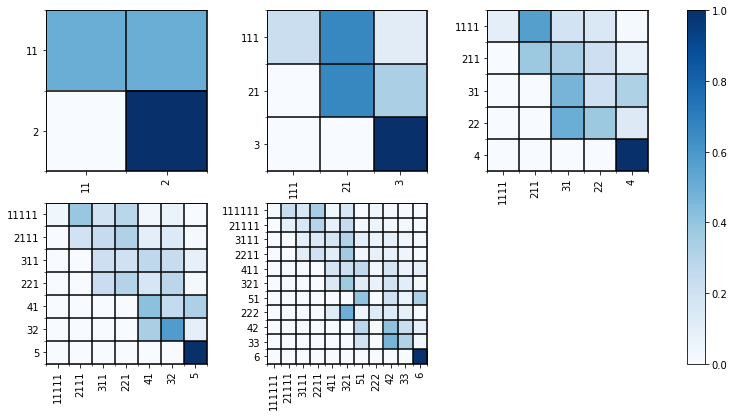

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(14,6.5))

for n_sides in range(2, 6 + 1):
    # Generate the transition matrices
    p, n_types, s_types = transition_matrix(n_sides)
    
    i, j = (n_sides - 2) // 3, (n_sides-2) % 3

    # Set ax and plot the image on it
    ax = axs[i][j]
    im = ax.imshow(p, cmap='Blues')

    # Minor ticks to add borders to squares
    # https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow
    ax.set_xticks(np.arange(-.5, n_types, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_types, 1), minor=True)        
    ax.grid(which='minor', color='k', linestyle='-', linewidth=1.5)
    
    # X-labels
    ax.set_xticks(np.arange(n_types))
    ax.set_xticklabels(s_types, rotation=90)

    # Y-labels
    ax.set_yticks(np.arange(n_types))
    ax.set_yticklabels(s_types, rotation=0)

fig.delaxes(axs[1, 2])
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()


### Computing the Exact Solution

Here we will solve the problem for 2 &ndash; 10 sided dies.

In [8]:
ps = dict()
mus = dict()
average_relabelings_exact = dict()
states = dict()

for n_sides in range(2, 10 + 1):
    # Generate the transition matrices
    p, n_types, s_types = transition_matrix(n_sides)
       
    # Solve for the mean time to absorption (mu)
    R = p[:-1,:-1]
    mu = np.linalg.solve(np.eye(n_types - 1, n_types - 1) - R, np.ones((n_types - 1,1)))
    
    # Append result to dict
    ps[n_sides] = deepcopy(p)
    mus[n_sides] = deepcopy(mu)
    average_relabelings_exact[n_sides] = mus[n_sides][0].item()
    states[n_sides] = deepcopy(s_types)

The results are displayed below in the <a href="#final_results" title="Jump to final results">Final Results section</a>.

## Simulation <a id="simulated_solution"></a>

In this section, we will simulate the relabeling process. The simulation is straightforward, so I won't provide too many details.

#### Helper function to check if sides are equal

The following function will be used to check to if the sides of a dice are all equal or not.

In [9]:
# https://stackoverflow.com/questions/3844801/check-if-all-elements-in-a-list-are-identical
def check_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == rest for rest in iterator)

The following two functions are used to simulate the rolling process.

In [10]:
# Simulate the process of rolling a single die untill the faces are all equal
def roll_until_same_face(n_sides):    
    n_relabelings = 0
    faces = np.arange(1, n_sides+1)
    
    while not check_equal(faces):        
        n_relabelings += 1
        faces = np.random.choice(faces, size = n_sides, replace=True)
    
    return n_relabelings

# Repeatedly simulate the rolling process
def repeat_roll_until_same_face(n_sides, n_repetitions, n_processors=1):
    n_relabelings = np.zeros(n_repetitions)

    with mp.Pool(n_processors) as p:        
        n_relabelings = p.map(lambda x: roll_until_same_face(n_sides), 
                              np.arange(n_repetitions))
    
    return n_relabelings

Now we simulate the process for dice with 2 &ndash; 10 faces.

In [11]:
n_repetitions = 100000

simulated_relabelings = dict()
average_relabelings_simulated = dict()

for n_sides in range(2, 10+1):
    n_relabelings = repeat_roll_until_same_face(n_sides, n_repetitions, 
                                                n_processors=4)
    simulated_relabelings[n_sides] = deepcopy(n_relabelings)
    average_relabelings_simulated[n_sides] = np.mean(n_relabelings)

## Final Results <a id="final_results"></a>

Finally, we compare the simulation results to the exact results.

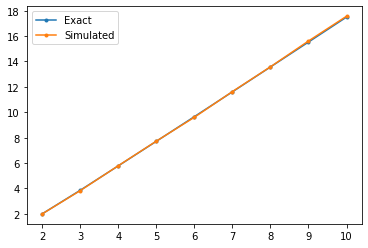

In [12]:
plt.plot(list(average_relabelings_exact.keys()),
         list(average_relabelings_exact.values()), 
         marker='.',
        label='Exact')
plt.plot(list(average_relabelings_simulated.keys()),
         list(average_relabelings_simulated.values()), 
         marker='.', 
         label = "Simulated")
plt.legend()
plt.show()

In [13]:
df = pd.DataFrame({
    'Number of Sides' : list(average_relabelings_exact.keys()),
    'Simulated' : list(average_relabelings_simulated.values()),
    'Exact' : list(average_relabelings_exact.values())}
)

df.style.hide_index().set_caption("Average # of Rounds Until Sides are Equal")


Number of Sides,Simulated,Exact
2,1.995920,2.000000
3,3.829160,3.857143
4,5.789280,5.779310
5,7.725520,7.711982
6,9.605560,9.655991
7,11.629240,11.608147
8,13.579080,13.566288
9,15.612280,15.529088
10,17.562040,17.495620
